## Risk metrics and hedging

## VAR 
It uses the past observed distribution of portfolio returns to estimate what your future losses might be at different likelihood levels. 
closed form formula for Normal VaR is mu-sigma*Z

In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

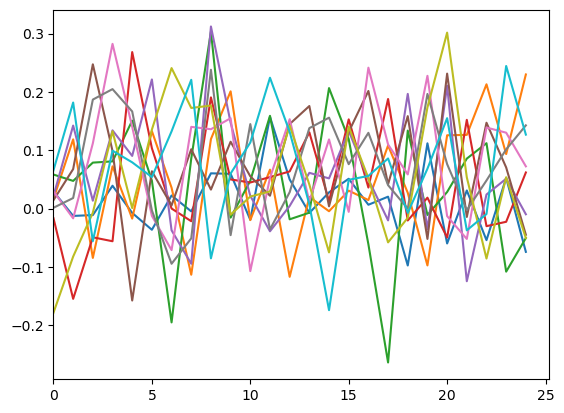

In [2]:
# generating some normal returns  data of 10 assets with random weights for 1 year

mu=0.05
sigma=0.1
n=10 # no. of assets
days=252
returns=np.random.normal(mu,sigma,(days,10))
names = ['Asset %s' %i  for i in range(1,n+1)]
returns = pd.DataFrame(returns, columns=names)
returns[:25].plot(legend=False)
plt.xlim(left=0)
plt.show()

In [3]:
weights=np.repeat(1/n,n)
portfolio_returns = returns.dot(weights)

In [4]:
type(portfolio_returns)

pandas.core.series.Series

In [5]:
def var(returns,confidence_interval,weight):
    portfolio_returns = returns.dot(weight)
    k=portfolio_returns.mean()
    std=portfolio_returns.std(ddof=1)
    return k-norm.ppf(confidence_interval)*std # assuming unit investment and normal distribution

In [6]:
var(returns,0.95,weights)

-0.007157812627853921

In [7]:
np.percentile(returns.dot(weights), 0.05)

-0.03937579203963946

## CVar or Expected shortfall
It is an expectation over all the different possible losses greater than VaR and their corresponding estimated likelihoods.
$$ {\displaystyle \operatorname {ES} _{\alpha }(X)=-{\frac {1}{\alpha }}\int _{0}^{\alpha }\operatorname {VaR} _{\gamma }(X)\,d\gamma } $$
If the loss of a portfolio L follows the normal distribution, the expected shortfall is equal to 

 $$  {\displaystyle \operatorname {ES} _{\alpha }(L)=\mu +\sigma {\frac {\varphi (\Phi ^{-1}(\alpha ))}{1-\alpha }}} $$

In [8]:
def cvar(returns,confidence_interval,weight):
    portfolio_returns = returns.dot(weight)
    k=portfolio_returns.mean()
    std=portfolio_returns.std(ddof=1)
    return k+std*((norm.pdf(norm.ppf(confidence_interval)))/(1-confidence_interval))
    

## historical or Non parametric Var
In real financial data the underlying distributions are rarely normal. This is why we prefer historical VaR as opposed to an assumption of an underlying distribution.

In [9]:
def historicalvar(returns,confidence_interval,weight):
    portfolio_returns = returns.dot(weight)
    portfolio_returns=np.sort(portfolio_returns)
    return portfolio_returns[int((1-confidence_interval)*len(portfolio_returns))-1]
    

In [10]:
# but this can give errors if number is not proper integer so better to use percentile function 

In [11]:
def historical_var(returns,confidence_interval,weight):
    portfolio_returns = returns.dot(weight)
    var=np.percentile(portfolio_returns,100*(1-confidence_interval))
    z=portfolio_returns[portfolio_returns<var].mean()
    plt.hist(portfolio_returns, bins=20)
    plt.axvline(var, color='red', linestyle='solid');
    plt.axvline(z, color='g', linestyle='-.');
    plt.legend(['VaR for specified alpha- '+str(confidence_interval),'Expected shortfall', 'Historical Returns Distribution'])
    plt.title('Historical VaR');
    plt.xlabel('Return');
    plt.ylabel('Observation Frequency');
    return var

def historical_ES(returns,confidence_interval,weight):
    var=historical_var(returns,confidence_interval,weight)
    portfolio_returns = returns.dot(weight)
    return portfolio_returns[portfolio_returns<var].mean()
    

-0.0008772570036502168

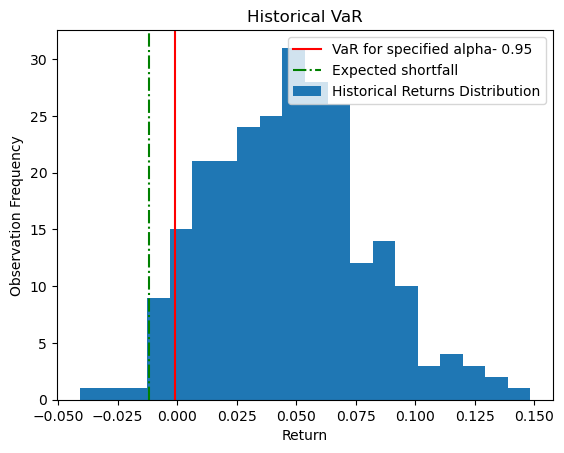

In [12]:
historical_var(returns,0.95,weights)

https://github.com/marketneutral/lectures/tree/master

After taking a look at all the risk metrics let us see how we can reduce risk by hedging beta as well as sector exposures.

Richard Grinold, Sharpe Ratio can be decomposed into two components, skill and breadth, as:<br>
       **IR=ICsqrt(BR)**<br>
Technically, this is the definition of the Information Ratio (IR), but for our purposes it is equivalent to the Sharpe Ratio as we can take absolute returns as benchmark=0.
In this equation skill is measured by IC. 
The IC is essentially the Spearman rank correlation, used to correlate your prediction and its realization. Breadth is measured as the number of independent bets in the period. The takeaway from this "law" is that, with any strategy, we need to:

1.Bet well (high IC),<br>
2.Bet often (high number of bets), and<br>
3.**Make independent bets**.The bets are not independent then the effective breadth can be much much less than the number of assets. 


We define a bet as the forecast of the residual of a security return.Without any fancy math, this simply means the return less a hedge.

In [13]:
# In all examples we will use Ledoit-Wolf instead of typical sample covariance to calculate covariance as it is more robust in response
#to out of sample data and outliers.
from sklearn.covariance import LedoitWolf as lw

**Example 1 without any hedge.**<br>
Here resisual is the return itself.

In [14]:

tickers = ['INFY.NS', 'TCS.NS',  'HDFCBANK.NS','AXISBANK.NS']
prices=yf.download(tickers,start="2022-01-01",end="2023-10-10",group_by='ticker')

[*********************100%%**********************]  4 of 4 completed


In [15]:
closing_price=pd.DataFrame()
rets=pd.DataFrame()
for x in tickers:
    closing_price[x] = prices[x]['Close']
    rets[x] = prices[x]['Close'].pct_change().fillna(0) 
cov = lw().fit(rets).covariance_

In [16]:
rets

,INFY.NS,TCS.NS,HDFCBANK.NS,AXISBANK.NS
Date,,,,
2022-01-03,0.000000,0.000000,0.000000,0.000000
2022-01-04,0.000369,0.017550,0.005857,0.018382
2022-01-05,-0.028697,-0.006127,0.023748,0.025030
2022-01-06,-0.014556,-0.013857,-0.016040,0.004677
2022-01-07,-0.001925,0.012095,0.007014,0.000411
...,...,...,...,...
2023-10-03,-0.001010,-0.004180,-0.011957,0.004196
2023-10-04,0.007218,0.006802,0.014257,-0.043706
2023-10-05,0.013224,0.014586,0.004053,0.007734


converting covariance into correlation
 Assume your covariance matrix is Σ
 and let

D=√diag(Σ)
then the correlation matrix is given by
ϱ=Dinv.Σ.Dinv


In [17]:
def get_corr(cov_matrix):
    d=np.diag(np.sqrt(np.diag(cov_matrix)))
    dinv = np.linalg.inv(d)
    corr = dinv.dot(cov_matrix).dot(dinv)
    return corr

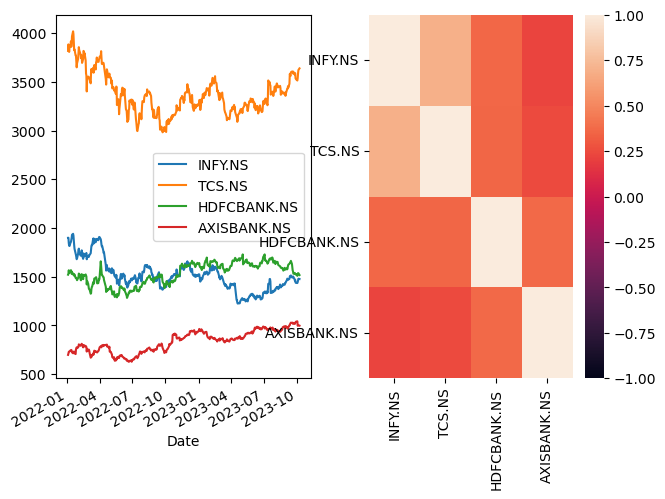

In [18]:
## plotting correlations graphically
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = get_corr(cov)
left = closing_price.plot(ax=ax1)
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)

In [19]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print ('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.3752


**Example 2 Beta hegde**<br>
we will assume that each bet is hedged against the market (BSE). In this case, the residual is calculated as:<br>
          residual= return_of_portfolio-beta*return_of_market



In [20]:
tickers = ['INFY.NS', 'TCS.NS',  'HDFCBANK.NS','AXISBANK.NS','^NSEI']
prices=yf.download(tickers,start="2022-01-01",end="2023-10-10",group_by='ticker')
closing_price=pd.DataFrame()
rets=pd.DataFrame()
for x in tickers:
    closing_price[x] = prices[x]['Close']
    rets[x] = prices[x]['Close'].pct_change().fillna(0) 
market=rets['^NSEI']
rets.drop(columns=['^NSEI'],inplace=True)

[*********************100%%**********************]  5 of 5 completed


In [21]:
residuals=pd.DataFrame()
for stock in rets.columns:
    model = sm.OLS(rets[stock], market)
    results = model.fit()
    residuals[stock] = results.resid


In [22]:
residuals

,INFY.NS,TCS.NS,HDFCBANK.NS,AXISBANK.NS
Date,,,,
2022-01-03,0.000000,0.000000,0.000000,0.000000
2022-01-04,-0.011185,0.008233,-0.005497,0.007962
2022-01-05,-0.036341,-0.012290,0.016237,0.018136
2022-01-06,-0.003208,-0.004707,-0.004889,0.014911
2022-01-07,-0.006195,0.008652,0.002819,-0.003439
...,...,...,...,...
2023-10-03,0.005317,0.000921,-0.005740,0.009902
2023-10-04,0.012598,0.011140,0.019544,-0.038853
2023-10-05,0.006826,0.009426,-0.002234,0.001964


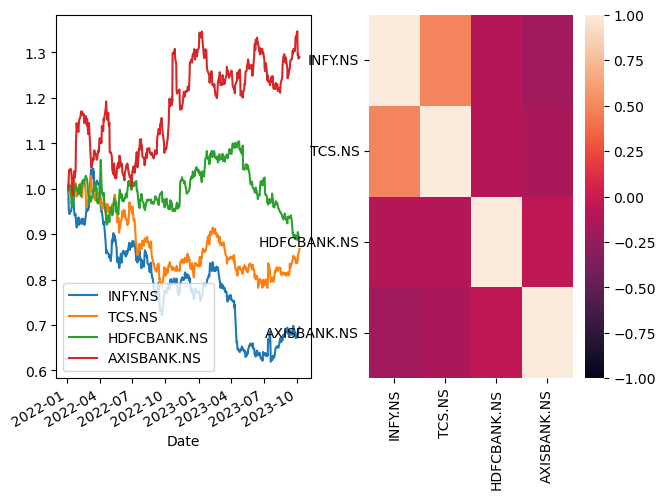

In [23]:
cov = lw().fit(residuals).covariance_ 

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()
tickers = ['INFY.NS', 'TCS.NS',  'HDFCBANK.NS','AXISBANK.NS']
corr = get_corr(cov)
left = (1+residuals).cumprod().plot(ax=ax1) 
# if I have hedged wrt to market the only effective return will be residuals
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)


In [24]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print ('Average pairwise correlation: %.4f' % average_corr)


Average pairwise correlation: -0.0247


We can see that beta hedging haas brought down the average correlation significanty. Theoretically, this should improve our breadth.
However there is still correlation due to multiple IT and banking stocks.Let us now move on to sector hedge.<br>
**Example 3 Sector Hedge**

The sector return and the market return are themselves highly correlated. As such, you cannot do a multivariate regression due to multicollinearity, a classic violation of regression assumptions. To hedge against both the market and a given security's sector, you first estimate the market beta residuals and then calculate the sector beta on those residuals.<br>
    sector_residual=R-sector_beta*r<br>
Here R is residuals of stock wrt to market and r is residuals of specific sector wrt to market. 


We will use nse as proxy for market and banknifty and nse IT as proxies for banking and IT sector.

In [31]:
tickers = ['INFY.NS','TCS.NS','HDFCBANK.NS','AXISBANK.NS','^NSEI','^NSEBANK','^CNXIT']
prices=yf.download(tickers,start="2022-01-01",end="2023-10-10",group_by='ticker')
rets=pd.DataFrame()

for x in tickers:
    rets[x] = prices[x]['Close'].pct_change().fillna(0) 
bank_sector=rets['^NSEBANK']
IT_sector=rets['^CNXIT']
market=rets['^NSEI']

rets.drop(columns=['^NSEI','^NSEBANK','^CNXIT'],inplace=True)


[*********************100%%**********************]  7 of 7 completed


In [32]:
#Calculate market beta of bank sector  benchmark
model = sm.OLS(bank_sector, market)
results = model.fit()
bank_sector_excess = results.resid
#Calculate market beta of sector 2 benchmark
model = sm.OLS(IT_sector, market)
results = model.fit()
IT_sector_excess = results.resid


In [33]:
residuals_market = rets.copy()*0
residuals = rets.copy()*0
bankstocks=['HDFCBANK.NS','AXISBANK.NS']
ITstocks=['INFY.NS', 'TCS.NS']


for stock in bankstocks:
    # Calculate market betas for sector 1 stocks
    model = sm.OLS(rets[stock], market)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], bank_sector_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid
    
# repeating whole process for IT stocks
for stock in ITstocks:
    model = sm.OLS(rets[stock], market)
    results = model.fit()
    residuals_market[stock] = results.resid
    model = sm.OLS(residuals_market[stock], IT_sector_excess)
    results = model.fit()
    residuals[stock] = results.resid

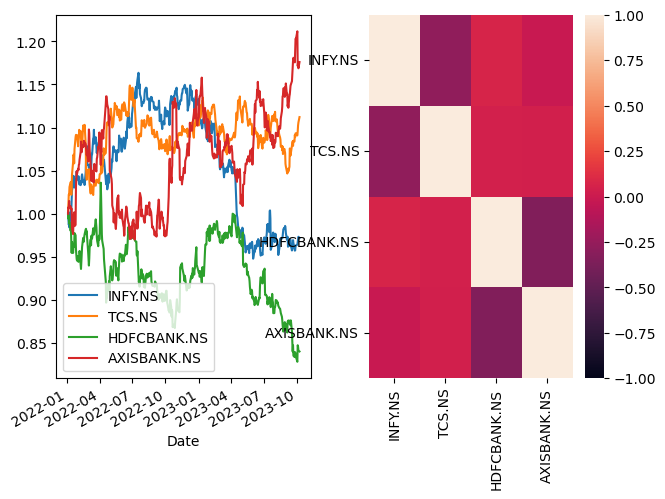

In [34]:
cov = lw().fit(residuals).covariance_
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()
tickers = ['INFY.NS', 'TCS.NS',  'HDFCBANK.NS','AXISBANK.NS']
corr = get_corr(cov)
left = (1+residuals).cumprod().plot(ax=ax1)
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)


In [35]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print ('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: -0.0804


In [30]:
# further reduction in correlation